Scores de Validação Cruzada: [-3.12643126 -0.56766693 -3.68556538  0.2213065  -0.27460687 -0.04018511
 -1.00331174 -1.68370159]
Melhores parâmetros: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
Erro Absoluto Médio TESTE: 0.05407986111111127
Erro Absoluto Médio TREINO: 0.015860696517412898


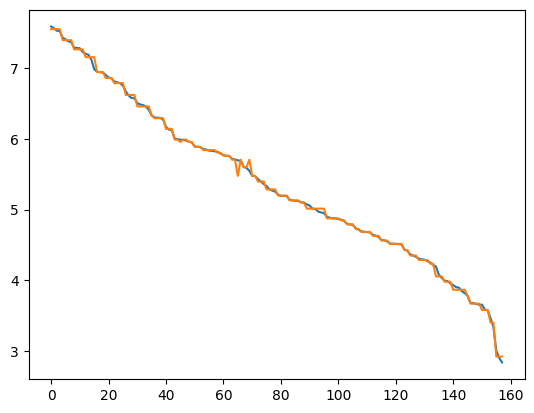

Gráfico com valores suavizados


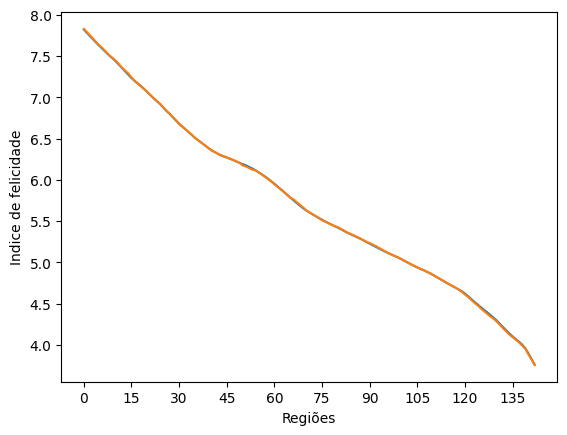

In [11]:
import pandas as pd
from joblib import dump
from sklearn.calibration import LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor  # Importando o DecisionTreeRegressor
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# Carregar o dataset
df = pd.read_csv('2015.csv')

# Pre-processamento
Y = df['Happiness Score']
X = df.drop( ['Country', 'Happiness Score'], axis = 1)

lb = LabelEncoder()
X['Region'] = lb.fit_transform(X['Region'])

# Validação cruzada para avaliar o desempenho inicial do modelo (usando DecisionTreeRegressor)
scores = cross_val_score(DecisionTreeRegressor(), X, Y, cv = 8)  # Usando o DecisionTreeRegressor
print("Scores de Validação Cruzada:", scores)

# PCA (redução de dimensionalidade)
pca = PCA(n_components = 8)
pca.fit(X)
X = pca.transform(X)

# Divisão em treino e teste
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)

"""
max_depth:
Definição: Controla a profundidade máxima da árvore de decisão. Ou seja, limita o número de níveis de decisão que a árvore pode ter. Cada nível corresponde a uma divisão (ou "nó") com base nas características do dado.
Efeito:
Árvores rasas (com profundidade baixa) podem não capturar bem a complexidade dos dados e resultar em underfitting (modelo simples demais).
Árvores profundas (com profundidade alta) podem acabar overfitting (modelo excessivamente ajustado aos dados de treinamento), capturando até o ruído.
Exemplo de valores:
3: A árvore terá no máximo 3 divisões de nível.
5: Limita a árvore a 5 divisões de nível.
7: Limita a árvore a 7 divisões de nível.
10: Limita a árvore a 10 divisões de nível.
Por que testar diferentes valores? Testando diferentes profundidades, você consegue encontrar um equilíbrio entre a capacidade do modelo de aprender as relações dos dados e a complexidade da árvore, evitando o overfitting.

min_samples_split:
Definição: Determina o número mínimo de amostras necessárias para que um nó (ou ponto de decisão) possa ser dividido em dois. Em outras palavras, se um nó tiver menos que esse número de amostras, ele não será dividido mais.
Efeito:
Valor baixo (ex: 2): Permite divisões mais "finas", onde a árvore pode se ajustar de forma muito específica aos dados (possivelmente overfitting).
Valor alto (ex: 10): A árvore terá que ter mais amostras para dividir um nó, o que leva a uma árvore mais "grosseira" e pode reduzir o overfitting, mas pode também resultar em underfitting.
Exemplo de valores:
2: O nó pode ser dividido mesmo com 2 amostras (divisões mais detalhadas).
5: O nó precisa de 5 amostras para ser dividido.
10: O nó precisa de 10 amostras para ser dividido.
Por que testar diferentes valores? Ajustar esse parâmetro ajuda a controlar o grau de detalhamento da árvore. Valores baixos podem resultar em árvores muito complexas, enquanto valores mais altos podem resultar em árvores muito simples.

min_samples_leaf:
Definição: Define o número mínimo de amostras necessárias para estar em uma folha (ou ponto de decisão final da árvore). Ou seja, um nó final só será criado se houver pelo menos esse número de amostras na folha.
Efeito:
Valor baixo (ex: 1): Isso permite que o modelo crie folhas com apenas uma amostra, o que pode levar a uma árvore muito específica (overfitting).
Valor alto (ex: 5): Isso força a árvore a fazer divisões mais gerais, o que pode evitar overfitting e melhorar a generalização, mas também pode tornar o modelo muito simples (underfitting).
Exemplo de valores:
1: A folha pode ter apenas uma amostra.
2: A folha precisa ter pelo menos 2 amostras.
5: A folha precisa ter pelo menos 5 amostras.
Por que testar diferentes valores? Ajustar esse parâmetro controla a granularidade das folhas. Um valor baixo permite divisões mais finas, mas pode aumentar o overfitting. Valores mais altos podem simplificar o modelo, mas há risco de underfitting.

"""
model = GridSearchCV(
    DecisionTreeRegressor(),
    {
        'max_depth': [3, 5, 7, 10],  # Ajustando profundidade da árvore
        'min_samples_split': [2, 5, 10],  # Ajustando número mínimo de amostras para dividir
        'min_samples_leaf': [1, 2, 5]  # Ajustando número mínimo de amostras por folha
    },
    n_jobs=4
)

# Treinando o modelo
model.fit(X_train, Y_train)
print("Melhores parâmetros:", model.best_params_)
model = model.best_estimator_

# Salvando o modelo treinado
dump(model, 'model.pkl')

# Calculando o erro absoluto médio
print("Erro Absoluto Médio TESTE:", mean_absolute_error(Y_test, model.predict(X_test)))
print("Erro Absoluto Médio TREINO:", mean_absolute_error(Y_train, model.predict(X_train)))

# Previsões
Ypred = model.predict(X)

# Plotando os resultados reais vs previsões
plt.plot(Y)
plt.plot(Ypred)
plt.show()

plt.ylabel('Indice de felicidade')
plt.xlabel('Regiões')
# Calculando a média móvel para suavizar as previsões e os valores reais

""" 
Loop for:

Para cada valor em Y (que é o vetor de valores reais), o código faz o seguinte:
Adiciona o valor de Y[i] (valor real) na lista wR.
Adiciona o valor de Ypred[i] (valor previsto) na lista wP.
Quando a lista wR tem mais de 15 elementos (após ter armazenado 15 valores), o código calcula a média dos últimos 15 valores em wR e em wP e a armazena em Ymm e Ypmm, respectivamente.
Em seguida, ele remove o primeiro valor da lista wR e wP (pop), para manter sempre apenas os últimos 15 valores.
Média Móvel:

A média móvel é uma técnica usada para suavizar séries temporais, eliminando flutuações pequenas e ajudando a identificar tendências de longo prazo.
No caso de Ymm e Ypmm, ele está calculando a média dos últimos 15 pontos de dados para cada momento. Isso ajuda a mostrar a tendência geral dos valores reais e previstos sem ser "distorcido" por flutuações pontuais.

"""

print("Gráfico com valores suavizados")

plt.ylabel('Indice de felicidade')
plt.xlabel('Regiões')

wR = []
wP = []
Ymm = []
Ypmm = []

for i in range(len(Y)):
    wR.append(Y[i])
    wP.append(Ypred[i])
    if len(wR) > 15:
        Ymm.append(sum(wR) / 15)
        Ypmm.append(sum(wP) / 15)
        wR.pop(0)
        wP.pop(0)

# Plotando as médias móveis
plt.plot(Ymm)
plt.plot(Ypmm)
plt.xticks(range(0, len(Ymm), 15))  # Ajusta o eixo x para mostrar valores de 15 em 15
plt.show()

